<a href="https://colab.research.google.com/github/MaximusThomas/ML-Projects/blob/main/convnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Network From Scratch

Binary classification CNN using just NumPy, linear algebra, and calculus with no PyTorch or TensorFlow.

Fully vectorized to ensure efficient inference and training.

[GitHub repo](https://github.com/MaximusThomas/ML-Projects)

In [25]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [26]:
def convolution(A_prev, filters, biases, n_s, n_p):
    '''
    Single convolutional layer of all filters, assuming ReLU activation

    Args:
        A_prev ((m, n_H, n_W, n_C)): matrix of activations
        filters ((n_filters, n_f, n_f, n_C)): filters
        biases (n_filters): bias term for each filter
        n_s (int): convolution stride
        n_p (int): amount of padding (assumes square symmetrical)

    Returns:
        A_next ((m, n_H_, n_W_, n_filters)): output matrix of activations
        cache (dict): Python dictionary containing keys "A_prev", "filters", "biases", "stride", "padding"
    '''

    # Get filter shape and activation height and width
    n_f, n_filters = filters.shape[1], filters.shape[0]
    m, n_H, n_W = A_prev.shape[0], A_prev.shape[1], A_prev.shape[2]

    # Calculate output height and width
    n_H_ = int(np.floor((n_H + (2 * n_p) - n_f) / n_s)) + 1
    n_W_ = int(np.floor((n_W + (2 * n_p) - n_f) / n_s)) + 1

    # Pad the input activation matrix
    A_prev_pad = np.pad(A_prev,
                        pad_width=((0, 0), (n_p, n_p), (n_p, n_p), (0, 0)),
                        mode='constant')

    Z = np.zeros((m, n_H_, n_W_, n_filters))

    # Cache required values
    cache = {}
    cache['A_prev'], cache['filters'], cache['biases'] = A_prev, filters, biases
    cache['stride'], cache['padding'] = n_s, n_p

    # Loop over all examples
    for i in range(m):

        # Loop over all filter positions
        for h in range(n_H_):
            for w in range(n_W_):

                # Loop over all filters; returns filter of shape (n_f, n_f, n_C)
                for filter_idx, (bias, filter) in enumerate(zip(biases, filters)):

                    # Calculate indices for activation matrix slicing
                    vert_start = h * n_s
                    vert_end = vert_start + n_f
                    horiz_start = w * n_s
                    horiz_end = horiz_start + n_f

                    # Element-wise multiplication and
                    z = (A_prev_pad[i, vert_start:vert_end, horiz_start:horiz_end, :] *  filter) + bias
                    z = np.sum(z)
                    Z[i, h, w, filter_idx] = z


    cache['Z'] = Z
    # ReLU activation function
    A_next = np.maximum(Z, 0)
    cache['A_next'] = A_next

    return A_next, cache

In [27]:
def vectorized_convolution(A_prev, filters, biases, n_s, n_p):
    '''
    Single convolutional layer of all filters, assuming ReLU activation

    Args:
        A_prev ((m, n_H, n_W, n_C)): matrix of activations
        filters ((n_filters, n_f, n_f, n_C)): filters
        biases (n_filters): bias term for each filter
        n_s (int): convolution stride
        n_p (int): amount of padding (assumes square symmetrical)

    Returns:
        A_next ((m, n_H_, n_W_, n_filters)): output matrix of activations
        cache (dict): Python dictionary containing keys "A_prev", "A_next", "filters", "biases", "stride", "padding", "Z"
    '''
    # Get filter shape and activation height and width
    n_f, n_filters = filters.shape[1], filters.shape[0]
    (m, n_H, n_W, n_C) = A_prev.shape

    # Calculate output height and width
    n_H_ = int(np.floor((n_H + (2 * n_p) - n_f) / n_s)) + 1
    n_W_ = int(np.floor((n_W + (2 * n_p) - n_f) / n_s)) + 1

    # Pad the input activation matrix
    A_prev_pad = np.pad(A_prev,
                        pad_width=((0, 0), (n_p, n_p), (n_p, n_p), (0, 0)),
                        mode='constant')

    # Cache required values
    cache = {}
    cache['A_prev'], cache['filters'], cache['biases'] = A_prev, filters, biases
    cache['stride'], cache['padding'] = n_s, n_p

    # Create view of sliding windows
    shape = (m, n_H_, n_W_, n_f, n_f, n_C)
    strides = (A_prev_pad.strides[0],
               n_s * A_prev_pad.strides[1],
               n_s * A_prev_pad.strides[2],
               A_prev_pad.strides[1],
               A_prev_pad.strides[2],
               A_prev_pad.strides[3])

    # Create windows matrix
    windows = np.lib.stride_tricks.as_strided(A_prev_pad, shape=shape, strides=strides)

    # Reshape for matmul
    A_reshaped = windows.reshape(m * n_H_ * n_W_, -1)
    filters_reshaped = filters.reshape(n_filters, -1)
    cache['A_reshaped'] = A_reshaped

    # Matrix multiplication and bias terms
    Z = np.dot(filters_reshaped, A_reshaped.T) + biases.reshape(-1, 1)

    # Reshape and traspose
    Z_reshaped = Z.reshape(n_filters, m, n_H_, n_W_).transpose(1, 2, 3, 0)

    # ReLU activation function
    A_next = np.maximum(Z_reshaped, 0)

    # Cache important values for backprop
    cache['A_next'], cache['Z'] = A_next, Z_reshaped

    return A_next, cache

In [28]:
def max_pool(A_prev, pool_size, n_s):
    '''
    Max pooling step across all examples and filters

    Args:
        A_prev ((m, n_H, n_W, n_C)): matrix of activations
        pool_size (int): size of pool, assuming square
        n_s (int): stride

    Returns:
        A_next ((m, n_H_, n_W_, n_filters)): pooled output matrix of activations
        cache (dict): Python dictionary containing keys "A_prev", "pool_size", "stride"
    '''

    # Calculate output dimensions
    m, n_H, n_W, n_C = A_prev.shape[0], A_prev.shape[1], A_prev.shape[2], A_prev.shape[3]
    n_H_, n_W_ = int(np.floor((n_H - pool_size) / n_s)) + 1, int(np.floor((n_W - pool_size) / n_s)) + 1

    A_next = np.zeros((m, n_H_, n_W_, n_C))
    mask = np.zeros_like(A_prev)

    # Cache values for backprop
    cache = {}
    cache['A_prev'], cache['pool_size'], cache['stride'] = A_prev, pool_size, n_s
    # Loop over training examples
    for i in range(m):

        # Loop over all pooling positions
        for h in range(int(n_H_)):
            for w in range(int(n_W_)):

                # Calculate indices for activation matrix slicing
                vert_start = h * n_s
                vert_end = vert_start + pool_size
                horiz_start = w * n_s
                horiz_end = horiz_start + pool_size

                # Take np.max() across channels returning a vector and add into A_next
                window = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, :]
                A_next[i, h, w, :] = np.max(window, axis=(0, 1))

                # Create mask for backpropagation
                mask_slice = (window == np.max(window, axis=(0, 1), keepdims=True))
                mask[i, vert_start:vert_end, horiz_start:horiz_end, :] = mask_slice

    cache['mask'] = mask
    return A_next, cache

In [29]:
def max_pool_vectorized(A_prev, pool_size, n_s):
    '''
    Max pooling step across all examples and filters

    Args:
        A_prev ((m, n_H, n_W, n_C)): matrix of activations
        pool_size (int): size of pool, assuming square
        n_s (int): stride

    Returns:
        A_next ((m, n_H_, n_W_, n_filters)): pooled output matrix of activations
        cache (dict): Python dictionary containing keys "A_prev", "pool_size", "stride"
    '''

    # Calculate output dimensions
    (m, n_H, n_W, n_C) = A_prev.shape
    n_H_ = int(np.floor((n_H - pool_size) / n_s)) + 1
    n_W_ = int(np.floor((n_W - pool_size) / n_s)) + 1

    # Cache values for backprop
    cache = {}
    cache['A_prev'], cache['pool_size'], cache['stride'] = A_prev, pool_size, n_s

    # Create windows
    shape = (m, n_H_, n_W_, pool_size, pool_size, n_C)
    strides = (A_prev.strides[0],
               n_s * A_prev.strides[1],
               n_s * A_prev.strides[2],
               A_prev.strides[1],
               A_prev.strides[2],
               A_prev.strides[3])

    windows = np.lib.stride_tricks.as_strided(A_prev, shape, strides)

    # Take max over each max pooling position
    A_next = np.max(windows.reshape(m, n_H_, n_W_, pool_size * pool_size, n_C), axis=3)

    return A_next, cache


In [30]:
def conv_back_prop(dA_next, cache):
    '''
    Back prop for a single convolution layer

    Args:
        dZ ((m, n_H_, n_W_, n_filters)): gradient of linear dot product output
        cache (): cache of A_prev, filters (weights), stride, and padding
    '''

    # Obtain required variables from layer cache
    Z_linear_output = cache['Z']
    A_prev = cache['A_prev']
    filters = cache['filters']
    n_s = cache['stride']
    n_p = cache['padding']
    A_next = cache['A_next']

    # Get shapes
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    n_filters, n_f, _, _ = filters.shape

    dZ = dA_next * (A_next > 0)
    m_dZ, n_H_out, n_W_out, _ = dZ.shape

    # Initialize gradients
    db = np.zeros((n_filters))
    dW = np.zeros_like(filters) # dW has shape (n_filters, n_f, n_f, n_C_prev)
    dA_prev = np.zeros_like(A_prev) # dA_prev has shape (m, n_H_prev, n_W_prev, n_C_prev)

    # Pad dA_prev for gradient accumulation
    dA_prev_pad = np.pad(dA_prev,
                         pad_width=((0, 0), (n_p, n_p), (n_p, n_p), (0, 0)),
                         mode='constant')

    # Pad A_prev for calculations (this is the A_prev_pad used in forward pass)
    A_prev_padded = np.pad(A_prev,
                         pad_width=((0, 0), (n_p, n_p), (n_p, n_p), (0, 0)),
                         mode='constant')

    # Loop over all training examples
    for i in range(m):
        # Loop over output positions
        for h_out in range(n_H_out):
            for w_out in range(n_W_out):
                vert_start = h_out * n_s
                vert_end = vert_start + n_f
                horiz_start = w_out * n_s
                horiz_end = horiz_start + n_f

                # Slice the relevant window from A_prev_padded
                A_prev_window = A_prev_padded[i, vert_start:vert_end, horiz_start:horiz_end, :]

                # Loop over all filters
                for filter_idx in range(n_filters):
                    current_filter = filters[filter_idx, :, :, :] # Shape (n_f, n_f, n_C_prev)

                    # Accumulate gradient for A_prev_pad
                    # dL/dA_prev_element += dL/dZ_element * W_element
                    dA_prev_pad[i, vert_start:vert_end, horiz_start:horiz_end, :] += \
                        current_filter * dZ[i, h_out, w_out, filter_idx]

                    # Accumulate gradient for W (filters)
                    # dL/dW_element += A_prev_element * dL/dZ_element
                    dW[filter_idx, :, :, :] += A_prev_window * dZ[i, h_out, w_out, filter_idx]

                    # Accumulate gradient for b (bias)
                    # dL/db_element += dL/dZ_element
                    db[filter_idx] += dZ[i, h_out, w_out, filter_idx]

    # Unpad dA_prev_pad to get dA_prev (gradient w.r.t. unpadded input to this layer)
    if n_p > 0:
        dA_prev = dA_prev_pad[:, n_p:-n_p, n_p:-n_p, :]
    else:
        dA_prev = dA_prev_pad

    return dA_prev, dW, db

In [31]:
def vec_conv_back_prop(dA_next, cache):
    '''
    Back prop for a single convolution layer

    Args:
        dA ((m, n_H_, n_W_, n_filters)): gradient of ReLU activations
        cache (): cache of A_prev, filters (weights), stride, and padding
    '''

    # Retrieve cached values
    A_prev = cache['A_prev']
    W = cache['filters']
    n_f = W.shape[1]
    n_s = cache['stride']
    n_p = cache['padding']
    Z = cache['Z']
    A_reshaped = cache['A_reshaped'] # A_reshaped is (m * n_H_out * n_W_out, n_f * n_f * n_C) from forward pass

    # Differentiate with respect to linear activations
    dZ = dA_next * (Z > 0)

    # Reshape for im2col matrix multiplication
    n_filters = W.shape[0] # Get n_filters from W shape
    m, n_H_out, n_W_out, _ = dZ.shape # Use dZ's actual shape for output dimensions

    dZ_reshaped = dZ.transpose(3, 0, 1, 2).reshape(n_filters, -1) # (n_filters, m * n_H_out * n_W_out)

    # Differentiate with respect to dW and db
    # dW should be (n_filters, n_f, n_f, n_C)
    # A_reshaped is (m * n_H_out * n_W_out, n_f * n_f * n_C)
    dW = np.dot(dZ_reshaped, A_reshaped).reshape(W.shape)
    db = np.sum(dZ, axis=(0, 1, 2)).reshape(n_filters, 1, 1)

    # Propagate gradient back to input activations
    W_reshaped = W.reshape(n_filters, -1) # (n_filters, n_f * n_f * n_C)
    dA_prev_reshaped = np.dot(W_reshaped.T, dZ_reshaped) # (n_f * n_f * n_C, m * n_H_out * n_W_out)

    # col2im
    (m_A, n_H_A, n_W_A, n_C_A) = A_prev.shape
    dA_prev_pad = np.zeros((m_A, n_H_A + (2 * n_p), n_W_A + (2 * n_p), n_C_A))

    # Reshape dA_prev_reshaped to match the windowed view from forward pass gradients
    # dA_prev_reshaped is (n_f * n_f * n_C_A, m * n_H_out * n_W_out)
    # We need it to be (m, n_H_out, n_W_out, n_f, n_f, n_C_A) to add back to dA_prev_pad
    d_windows = dA_prev_reshaped.T.reshape(m_A, n_H_out, n_W_out, n_f, n_f, n_C_A)

    # Iterate and sum overlapping gradients
    for i_ex in range(m_A):
        for h_out in range(n_H_out):
            for w_out in range(n_W_out):
                vert_start = h_out * n_s
                vert_end = vert_start + n_f
                horiz_start = w_out * n_s
                horiz_end = horiz_start + n_f

                # Add the gradients from this window to the corresponding slice of dA_prev_pad
                dA_prev_pad[i_ex, vert_start:vert_end, horiz_start:horiz_end, :] += d_windows[i_ex, h_out, w_out, :, :, :]

    # Remove padding
    if n_p > 0:
        dA_prev = dA_prev_pad[:, n_p:-n_p, n_p:-n_p, :]
    else:
        dA_prev = dA_prev_pad

    return dA_prev, dW, db

In [32]:
def max_pool_backprop(dA_next, A_prev, pool_size, n_s, mask):
    '''
    Backprop for a max pooling layer

    Args:
        dA_next ((m, n_H_, n_W_, n_filters)): tensor of activations from max pooling layer
        pool_size (int): size of pool, assuming square
        n_s (int): stride
        mask ((m, n_H, n_W, n_C)): tensor of either 0s or 1s corresponding to indices of max values

    Returns:
        dA_prev ((m, n_H, n_W, n_C)): tensor of activations from previous conv layer
    '''

    (m, n_H_, n_W_, n_C_) = dA_next.shape
    dA_prev = np.zeros_like(A_prev)

    # Loop over training examples
    for i in range(m):

        # Loop over dimensions
        for h in range(n_H_):
            for w in range(n_W_):

                # Get window positions
                vert_start = h * n_s
                vert_end = vert_start + pool_size
                horiz_start = h * n_s
                horiz_end = horiz_start + pool_size

                dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, :] += mask[i, vert_start:vert_end, horiz_start:horiz_end, :] * dA_next[i, h, w, :]

    return dA_prev

In [33]:
def vec_max_pool_backprop(dA_next, A_prev, pool_size, n_s):
  '''
  Backprop for a max pooling layer

  Args:
      dA_next ((m, n_H_, n_W_, n_filters)): tensor of activations from max pooling layer
      pool_size (int): size of pool, assuming square
      n_s (int): stride

  Returns:
      dA_prev ((m, n_H, n_W, n_C)): tensor of activations from previous conv layer
  '''

  # Retrieve shapes
  # dA_next is (m, n_H_out, n_W_out, n_C) from full_backprop after reshape
  (m, n_H_out, n_W_out, n_C) = dA_next.shape
  (m_A_prev, n_H_A_prev, n_W_A_prev, n_C_A_prev) = A_prev.shape

  # Calculate output dimensions for pooling based on A_prev
  n_H_pool = int(np.floor((n_H_A_prev - pool_size) / n_s)) + 1
  n_W_pool = int(np.floor((n_W_A_prev - pool_size) / n_s)) + 1

  # Create windows view on A_prev for mask generation
  shape_windows = (m_A_prev, n_H_pool, n_W_pool, pool_size, pool_size, n_C_A_prev)
  strides_windows = (A_prev.strides[0],
                     n_s * A_prev.strides[1],
                     n_s * A_prev.strides[2],
                     A_prev.strides[1],
                     A_prev.strides[2],
                     A_prev.strides[3])
  windows = np.lib.stride_tricks.as_strided(A_prev, shape=shape_windows, strides=strides_windows)

  # Create mask for max values (indices where max was taken in forward pass)
  A_prev_flat = windows.reshape(m_A_prev, n_H_pool, n_W_pool, pool_size * pool_size, n_C_A_prev)
  max_vals = np.max(A_prev_flat, axis=3, keepdims=True)
  mask = (A_prev_flat == max_vals) # Shape (m, n_H_pool, n_W_pool, pool_size*pool_size, n_C)

  # Reshape dA_next for broadcasting with mask
  dA_next_reshaped_for_mask = dA_next[:, :, :, np.newaxis, :] # (m, n_H_out, n_W_out, 1, n_C)

  # Apply mask to distribute gradients only to the maximum elements
  dA_col_flat = mask * dA_next_reshaped_for_mask # (m, n_H_pool, n_W_pool, pool_size*pool_size, n_C)
  dA_col = dA_col_flat.reshape(m_A_prev, n_H_pool, n_W_pool, pool_size, pool_size, n_C_A_prev) # (m, n_H_pool, n_W_pool, pool_size, pool_size, n_C)

  # col2im: Initialize dA_prev with zeros, then accumulate gradients
  dA_prev = np.zeros_like(A_prev)

  for i_ex in range(m_A_prev):
    for h_out in range(n_H_pool):
      for w_out in range(n_W_pool):
        vert_start = h_out * n_s
        vert_end = vert_start + pool_size
        horiz_start = w_out * n_s
        horiz_end = horiz_start + pool_size

        # Add the gradients for this specific window back into dA_prev
        dA_prev[i_ex, vert_start:vert_end, horiz_start:horiz_end, :] += dA_col[i_ex, h_out, w_out, :, :, :]

  return dA_prev

In [34]:
def sigmoid(x):

    x = np.clip(x, -500, 500)
    s = 1/(1+np.exp(-x))
    return s

In [35]:
def binary_cross_entropy_cost(yhat, y, epsilon = 1e-15):

    m = y.shape[1]
    yhat = np.clip(yhat, epsilon, 1 - epsilon)
    cost = -1/m * np.sum((y * np.log(yhat)) + ((1-y) * np.log(1-yhat)))
    return cost

In [36]:
def initialize_parameters(X, dense_dims, conv_params, conv_dims):

    m = X.shape[0]
    A_prev = X
    l = 1
    for dim in conv_dims:

      if dim == 'conv':

        # Single convolutional layer with ReLU activation
        A_next, _ = convolution(A_prev,
                                    filters=conv_params['W' + str(l)],
                                    biases=conv_params['b' + str(l)],
                                    n_s=conv_dims[dim]['n_s'],
                                    n_p=conv_dims[dim]['n_p'])
        l += 1

      elif dim == 'max_pool':
        A_next, _ = max_pool(A_prev, conv_dims[dim]['pool_size'], conv_dims[dim]['n_s'])

      A_prev = A_next

    dense_dims.insert(0, A_prev.reshape(-1, m).shape[0])

    parameters = {}
    for l in range(1, len(dense_dims)):
        parameters['W' + str(l)] = np.random.randn(dense_dims[l], dense_dims[l - 1]) * np.sqrt(2/dense_dims[l-1])
        parameters['b' + str(l)] = np.zeros((dense_dims[l], 1))

    return parameters


In [37]:
def dense_forward_prop(conv_prev, y, parameters):
    '''
    Forward prop for dense layers, flattening convolutional output, assuming ReLU activation and sigmoid output activation

    Args:
        conv_prev ((m, n_H, n_W, n_filters)): tensor of activations from final max pooling layer
        parameters (dict): dictionary containing all dense network parameters
            W ((n_l, n_l_prev)): matrix of weights
            b ((n_l, 1)): column vector of bias terms
        y ((1, m)): labels

    Returns:
        yhat ((1, m)): predictions from forward prop
    '''

    # Flatten A_prev into a 2D matrix
    m = conv_prev.shape[0]
    A_prev = conv_prev.reshape(-1, m)

    # Forward prop through dense network
    caches = []
    L = len(parameters) // 2
    for l in range(1, L):
        cache = {}

        # Calculate linear product
        Z = np.dot(parameters['W' + str(l)], A_prev) + parameters['b' + str(l)]
        cache['Z' + str(l)] = Z
        cache['W' + str(l)] = parameters['W' + str(l)]

        # Apply activation function
        A_next = np.maximum(Z, 0)
        cache['A' + str(l-1)] = A_prev
        A_prev = A_next

        # Append cache
        caches.append(cache)

    # Output layer
    cache = {}
    cache['A' + str(L-1)] = A_prev
    Z = np.dot(parameters['W' + str(L)], A_prev) + parameters['b' + str(L)]
    cache['Z' + str(L)] = Z
    cache['W' + str(L)] = parameters['W' + str(L)]
    caches.append(cache)
    yhat = sigmoid(Z)

    # Calculate loss
    cost = binary_cross_entropy_cost(yhat, y)

    return cost, yhat, caches



In [38]:
def dense_backprop(yhat, y, caches):
    '''
    Backprop for dense layers, assuming ReLU activation and sigmoid output activation

    Args:
        yhat ((1, m)): vector of activations of output layer for each example
        y ((1, m)): vector of labels for each training example
        caches (list): list of each layer's cache dictionary

    Returns:

    '''

    m = yhat.shape[1]
    grads = {}
    L = len(caches)

    # Backprop for output layer
    cache = caches[-1]
    grads['dZ' + str(L)] = yhat - y
    grads['dW' + str(L)] = 1/m * np.dot(grads['dZ' + str(L)], cache['A' + str(L-1)].T)
    grads['db' + str(L)] = 1/m * np.sum(grads['dZ' + str(L)], axis=1, keepdims=True)
    grads['dA' + str(L-1)] = np.dot(cache['W' + str(L)].T, grads['dZ' + str(L)])

    # Backprop for hidden layers
    for l in range(L-1, 0, -1):

        cache = caches[l-1]
        grads['dZ' + str(l)] = grads['dA' + str(l)] * (cache['Z' + str(l)] > 0)
        grads['dW' + str(l)] = 1/m * np.dot(grads['dZ' + str(l)], cache['A' + str(l-1)].T)
        grads['db' + str(l)] = 1/m * np.sum(grads['dZ' + str(l)], axis=1, keepdims=True)
        grads['dA' + str(l-1)] = np.dot(cache['W' + str(l)].T, grads['dZ' + str(l)])

    return grads

In [39]:
def initialize_convolution(X, conv_dims):
    '''
    Initializes parameters for convolutional part of network

    Args:
        X (((m, n_H, n_W, n_C)): input matrix
        conv_dims (dict): dict containing either 'conv', or 'max_pool' corresponding to a sub-dict
            conv (dict): dict with keys 'n_f', 'n_s', 'n_p', 'n_filters'
                n_f (int): kernel/filter size
                n_s (int): stride size
                n_p (int): padding size
                n_filters (int): number of filters
            max_pool (dict): dict with keys 'pool_size', 'n_s'
                pool_size (int): max pooling size
                n_s (int): max pooling stride

    Returns:
        conv_params (dict): dict containg keys 'Wl' (filters of layer l), and 'bl' (biases of layer l)
    '''

    conv_params = {}
    n_C = X.shape[-1]

    # Loop over architecture specifications in list
    for conv_dim in conv_dims:

        l = 1
        # Create params for only convolutional layers
        if conv_dim == 'conv':
            n_filters, n_f = conv_dims[conv_dim]['n_filters'], conv_dims[conv_dim]['n_f']
            conv_params['W' + str(l)] = np.random.randn(n_filters, n_f, n_f, n_C) * np.sqrt(2 / (n_f * n_f * n_C))
            conv_params['b' + str(l)] = np.zeros((n_filters, 1, 1))
            n_C = n_filters
            l += 1

    return conv_params


In [40]:
def full_forwardprop(X, y, conv_dims, dense_dims, params):
    '''
    Forward prop for both convolutional and dense sections of the network, assuming ReLU activation

    Args:
        X ((m, n_H, n_W, n_C)): input matrix
        conv_dims (dict): dict containing either 'conv', or 'max_pool' corresponding to a sub-dict
            conv (dict): dict with keys 'n_f', 'n_s', 'n_p', 'n_filters'
                n_f (int): kernel/filter size
                n_s (int): stride size
                n_p (int): padding size
                n_filters (int): number of filters
            max_pool (dict): dict with keys 'pool_size', 'n_s'
                pool_size (int): max pooling size
                n_s (int): max pooling stride

    Returns:
        yhat ((1, m)): predictions from forward prop
    '''
    (conv_params, dense_params) = params
    A_prev = X
    conv_caches = []
    l = 1

    # Enumerate through both convolutional and max pooling layers
    for dim in conv_dims:

      if dim == 'conv':

        # Single convolutional layer with ReLU activation
        A_next, cache = vectorized_convolution(A_prev,
                                    filters=conv_params['W' + str(l)],
                                    biases=conv_params['b' + str(l)],
                                    n_s=conv_dims[dim]['n_s'],
                                    n_p=conv_dims[dim]['n_p'])
        l += 1

      elif dim == 'max_pool':
        A_next, cache = max_pool_vectorized(A_prev, conv_dims[dim]['pool_size'], conv_dims[dim]['n_s'])

      conv_caches.append(cache)
      A_prev = A_next

    # Forward prop through dense layers
    cost, yhat, dense_caches = dense_forward_prop(A_prev, y, dense_params)

    return cost, yhat, dense_caches, conv_caches, A_next

In [41]:
def full_backprop(yhat, y, dense_caches, conv_caches, conv_dims, A_next):
    '''
    Backprop for both the dense and convolutional sections of the nework

    Args:
        yhat ((1, m)): vector of activations of output layer for each example
        y ((1, m)): vector of labels for each training example
        caches (list): list of each layer's cache dictionary
          cache (dict): Python dictionary containing
            A_prev ((m, n_H, n_W, n_C)): previous activation matrices
            filters ((n_filters, n_f, n_f, n_C)): filters
            biases (n_filters, 1): bias term for each filter
            stride (int): stride size
            padding (int): padding size
        conv_dims (dict): dict containing either 'conv', or 'max_pool' corresponding to a sub-dict
            conv (dict): dict with keys 'n_f', 'n_s', 'n_p', 'n_filters'
                n_f (int): kernel/filter size
                n_s (int): stride size
                n_p (int): padding size
                n_filters (int): number of filters
            max_pool (dict): dict with keys 'pool_size', 'n_s'
                pool_size (int): max pooling size
                n_s (int): max pooling stride

    Returns:
        dense_grads (dict): dict containg keys 'W + str(l)' and 'b + str(l)
        conv_grads (dict): dict containing keys 'W + str(l)' and 'b + str(l)
    '''

    # Full dense backprop
    dense_grads = dense_backprop(yhat, y, dense_caches)

    # Get gradient for output of dense section and reshape back to 4D
    shape = A_next.shape
    dA_next = dense_grads['dA0'].T.reshape(shape)

    conv_grads = {}

    # Create a mapping from cache index to conv layer number used in params
    conv_layer_numbers = []
    current_conv_l = 1
    for dim_type in conv_dims:

      if dim_type == 'conv':
        conv_layer_numbers.append(current_conv_l)
        current_conv_l += 1
      else: # For pooling layers, no conv param number
        conv_layer_numbers.append(None)

    # Iterate through conv_caches in reverse order for backpropagation
    for cache_idx in range(len(conv_caches) - 1, -1, -1):

      # Get current cache from caches
      conv_cache = conv_caches[cache_idx]
      dim_type = list(conv_dims.keys())[cache_idx] # Get the type of layer at this cache index

      # Backprop for convolutional layer
      if dim_type == 'conv':
        conv_layer_num = conv_layer_numbers[cache_idx]
        if conv_layer_num is None:
          raise ValueError(f"Mismatch in conv_layer_numbers and cache_idx for conv layer at index {cache_idx}")

        dA_prev, dW, db = vec_conv_back_prop(dA_next, conv_cache)

        # Update conv_grads dictionary using the correct 'l' (conv_layer_num)
        conv_grads['dW' + str(conv_layer_num)] = dW
        conv_grads['db' + str(conv_layer_num)] = db

      # Backprop for max pooling layer
      elif dim_type == 'max_pool':
        A_prev, pool_size, n_s = conv_cache['A_prev'], conv_cache['pool_size'], conv_cache['stride']
        dA_prev = vec_max_pool_backprop(dA_next, A_prev, pool_size, n_s)

      # Update dA_next
      dA_next = dA_prev

    # Return gradient dictionaries
    return conv_grads, dense_grads

In [42]:
def Adam(params, grads, S, V, iter, alpha=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
    '''
    Adam optimization algorithm, combining both RMSprop and gradient descent with momentum, as well as bias correction

    Args:
      parameters (tuple): tuple of conv_params and dense_params dictionaries
        conv_params (dict): dict containg keys 'Wl' (filters of layer l), and 'bl' (biases of layer l)
        dense_params (dict): dict with keys 'Wl' (weights of layer l) and 'bl' (biases of layer l)
      grads (tuple): tuple of conv_grads and dense_grads dicts
        conv_grads (dict): dict with keys 'dWl' and 'dbl' (i.e., the partial derivative of each parameter)
        dense_grads (dict): dict with keys 'dWl' and 'dbl' (i.e., the partial derivative of each parameter)
      S (tuple): contains exponential moving average of squared gradients dictionaries of conv_S and dense_S
      V (tuple): contains exponential moving average of gradients dictionaries of conv_V and dense_V

    Returns:
      parameters (tuple): updated tuple of conv_params and dense_params dictionaries
        conv_params (dict): updated dict containg keys 'Wl' (filters of layer l), and 'bl' (biases of layer l)
        dense_params (dict): updated dict with keys 'Wl' (weights of layer l) and 'bl' (biases of layer l)
      S (tuple): contains exponential moving average of squared gradients dictionaries of conv_S and dense_S
      V (tuple): contains exponential moving average of gradients dictionaries of conv_V and dense_V
    '''

    # Unpack tuples
    (conv_params, dense_params) = params
    (conv_grads, dense_grads) = grads
    (conv_S, dense_S) = S
    (conv_V, dense_V) = V

    # Iterate over all dense_params
    L = len(dense_params)//2
    for l in range(1, L+1):

        # Get gradients
        dWl, dbl = dense_grads['dW'+str(l)], dense_grads['db'+str(l)]

        # Update velocity terms
        dense_V['dW'+str(l)] = (beta1 * dense_V['dW'+str(l)]) + ((1-beta1) * dWl)
        dense_V['db'+str(l)] = (beta1 * dense_V['db'+str(l)]) + ((1-beta1) * dbl)

        # Update squared-gradient terms
        dense_S['dW' + str(l)] = (beta2 * dense_S['dW' + str(l)]) + ((1 - beta2) * np.square(dWl))
        dense_S['db' + str(l)] = (beta2 * dense_S['db' + str(l)]) + ((1 - beta2) * np.square(dbl))

        # Bias correction
        vdW_corrected = dense_V['dW'+str(l)] / (1 - (beta1 ** iter))
        vdb_corrected = dense_V['db'+str(l)] / (1 - (beta1 ** iter))

        sdW_corrected = dense_S['dW' + str(l)] / (1 - (beta2 ** iter))
        sdb_corrected = dense_S['db' + str(l)] / (1 - (beta2 ** iter))

        # Update Parameters
        dense_params['W'+str(l)] -= (alpha * vdW_corrected) / (np.sqrt(sdW_corrected)+epsilon)
        dense_params['b'+str(l)] -= (alpha * vdb_corrected) / (np.sqrt(sdb_corrected)+epsilon)

  # Iterate over all conv_params
    L = len(conv_params)//2
    for l in range(1, L+1):

        # Get gradients
        dWl, dbl = conv_grads['dW'+str(l)], conv_grads['db'+str(l)]

        # Update velocity terms
        conv_V['dW'+str(l)] = (beta1 * conv_V['dW'+str(l)]) + ((1-beta1) * dWl)
        conv_V['db'+str(l)] = (beta1 * conv_V['db'+str(l)]) + ((1-beta1) * dbl)

        # Update squared-gradient terms
        conv_S['dW' + str(l)] = (beta2 * conv_S['dW' + str(l)]) + ((1 - beta2) * np.square(dWl))
        conv_S['db' + str(l)] = (beta2 * conv_S['db' + str(l)]) + ((1 - beta2) * np.square(dbl))

        # Bias correction
        vdW_corrected = conv_V['dW'+str(l)] / (1 - (beta1 ** iter))
        vdb_corrected = conv_V['db'+str(l)] / (1 - (beta1 ** iter))

        sdW_corrected = conv_S['dW' + str(l)] / (1 - (beta2 ** iter))
        sdb_corrected = conv_S['db' + str(l)] / (1 - (beta2 ** iter))

        # Update Parameters
        conv_params['W'+str(l)] -= (alpha * vdW_corrected) / (np.sqrt(sdW_corrected)+epsilon)
        conv_params['b'+str(l)] -= (alpha * vdb_corrected) / (np.sqrt(sdb_corrected)+epsilon)

    # Repack tuples
    params = (conv_params, dense_params)
    S = (conv_S, dense_S)
    V = (conv_V, dense_V)

    return params, S, V

In [43]:
def initialize_adam(params):

  # Initialize adam
  (conv_params, dense_params) = params
  dense_S, conv_S, dense_V, conv_V = {}, {}, {}, {}
  S, V = (conv_S, dense_S), (conv_V, dense_V)

  # Loop over dense params
  L = len(dense_params)//2
  for l in range(1, L+1):

    # RMS prop terms
    dense_S['dW'+str(l)] = np.zeros_like(dense_params['W'+str(l)])
    dense_S['db'+str(l)] = np.zeros_like(dense_params['b'+str(l)])

    # Momentum terms
    dense_V['dW'+str(l)] = np.zeros_like(dense_params['W'+str(l)])
    dense_V['db'+str(l)] = np.zeros_like(dense_params['b'+str(l)])

  L = len(conv_params)//2
  for l in range(1, L+1):
    # RMS prop terms
    conv_S['dW'+str(l)] = np.zeros_like(conv_params['W'+str(l)])
    conv_S['db'+str(l)] = np.zeros_like(conv_params['b'+str(l)])

    # Momentum terms
    conv_V['dW'+str(l)] = np.zeros_like(conv_params['W'+str(l)])
    conv_V['db'+str(l)] = np.zeros_like(conv_params['b'+str(l)])

  S, V = (conv_S, dense_S), (conv_V, dense_V)

  return S, V



In [44]:
def train(X, y, X_test, y_test, dims, epochs=10):
    '''
    Forward and backprop to train CNN model

    Args:
        X ((m, n_H, n_W, n_C)): inputs
    '''
    # Extract network architecture
    (conv_dims, dense_dims) = dims

    # Initialize parameters
    conv_params = initialize_convolution(X, conv_dims)
    dense_params = initialize_parameters(X, dense_dims, conv_params, conv_dims)
    params = (conv_params, dense_params)

    # Initialize Adam's momentum and RMSprop terms once before training loop
    S, V = initialize_adam(params)

    # Empty list to record cost
    cost_history_train = []
    cost_history_test = []

    # Training loop
    for epoch in tqdm(range(1, epochs+1)):

      # Full forward prop
      cost, yhat, dense_caches, conv_caches, A_next = full_forwardprop(X, y, conv_dims, dense_dims, params)
      cost_history_train.append(cost)
      _, yhat_test, _, _, _ = full_forwardprop(X_test, y_test, conv_dims, dense_dims, params)
      cost_test = binary_cross_entropy_cost(yhat_test, y_test)
      cost_history_test.append(cost_test)

      # Full backprop
      conv_grads, dense_grads = full_backprop(yhat, y, dense_caches, conv_caches, conv_dims, A_next)
      grads = (conv_grads, dense_grads)

      # Adam optimization algorithm
      params, S, V = Adam(params, grads, S, V, epoch)

    cost_history = (cost_history_train, cost_history_test)

    return params, cost_history

In [45]:
def predict(X, y, params, dims):
  '''
  Forward prop to output predictions after training

  Args:
      X ((m, n_H, n_W, n_C)): inputs
      y ((m, 1)): outputs
  '''

  # Initialize network
  A_prev = X
  conv_caches = []
  l = 1

  # Extract network architecture
  (conv_dims, dense_dims) = dims

  # Inference
  _, yhat_raw, _, _, A_next = full_forwardprop(X, y, conv_dims, dense_dims, params)

  return (yhat_raw > 0.5), yhat_raw


In [46]:
import tensorflow as tf

# Load data
(train_X, train_y), (test_X, test_y) = tf.keras.datasets.mnist.load_data()

# Select classes 0 and 1 for binary classification
mask = (train_y == 0) | (train_y == 1)
train_X, train_y = train_X[mask.flatten()], train_y[mask]

# Reshape X to (m, n_H, n_W, n_C)
train_X = train_X.reshape(train_X.shape[0], 28, 28, 1)
test_X = test_X.reshape(test_X.shape[0], 28, 28, 1)

# Reshape y to (1, m)
train_y = train_y.reshape(1, train_y.shape[0])
test_y = test_y.reshape(1, test_y.shape[0])

# Normalization
train_X = train_X / 255.0
test_X = test_X / 255.0

In [47]:
train_X.shape

(12665, 28, 28, 1)

In [48]:
# Specify conv net architecture
conv_1 = {'n_f' : 3, 'n_s' : 1, 'n_p' : 0, 'n_filters' : 8}
pool_1 = {'pool_size' : 2, 'n_s' : 2}
conv_dims = {'conv' : conv_1, 'max_pool' : pool_1}

# Specify dense network architecture
dense_dims = [64, 1]

# Overall network architecture
dims = (conv_dims, dense_dims)

# Train network
params, cost_history = train(train_X[:1000, :, :, :], train_y[:, :1000], test_X, test_y, dims, epochs=1000)


  0%|          | 0/1000 [00:00<?, ?it/s]

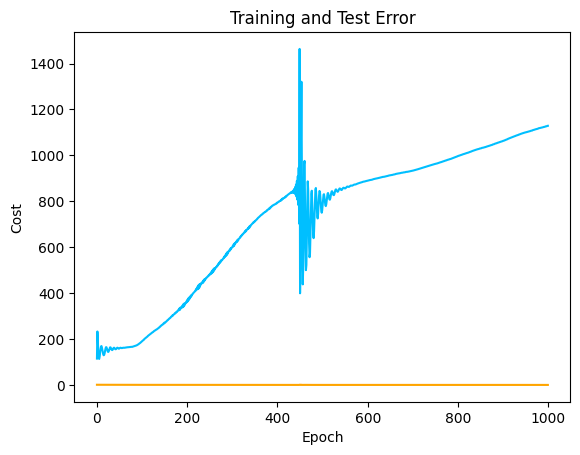

In [49]:
plt.plot(cost_history[0], color='orange')
plt.plot(cost_history[1], color='deepskyblue')
plt.title('Training and Test Error')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.show()

In [50]:
# Process for binary classification
mask = (test_y == 0) | (test_y == 1)
test_X, test_y = test_X[mask.flatten()], test_y[mask]

# Reshape y to (1, m)
test_y = test_y.reshape(1, test_y.shape[0])


# Inference
y_pred_binary, y_pred_raw = predict(test_X, test_y, params, dims)

# Model evaluation
print(f'Model accuracy: {accuracy_score(y_pred=y_pred_binary, y_true=test_y)}')

Model accuracy: 0.0


In [2]:
cost

NameError: name 'cost' is not defined